In [26]:
import yfinance as yf
import pandas as pd

df = yf.download("SPY", start="2010-01-01", auto_adjust=True)

# For flattening columns in a MultiIndex is returned
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.lower()

df.head(), df.tail(), df.shape

[*********************100%***********************]  1 of 1 completed


(Price           close       high        low       open     volume
 Date                                                             
 2010-01-04  85.027946  85.072961  83.662458  84.307689  118944600
 2010-01-05  85.253044  85.290560  84.667835  84.975448  111579900
 2010-01-06  85.313049  85.523124  85.102975  85.170496  116074400
 2010-01-07  85.673172  85.778209  84.915399  85.155485  131091100
 2010-01-08  85.958305  85.995821  85.275564  85.448122  126402800,
 Price            close        high         low        open    volume
 Date                                                                
 2025-12-24  690.380005  690.830017  687.799988  687.950012  39445600
 2025-12-26  690.309998  691.659973  689.270020  690.640015  41613300
 2025-12-29  687.849976  689.200012  686.070007  687.539978  62559500
 2025-12-30  687.010010  688.559998  686.580017  687.450012  47160700
 2025-12-31  681.919983  687.359985  681.710022  687.140015  74144800,
 (4024, 5))

In [ ]:
import yfinance as yf
import pandas as pd

df = yf.download("SPY", start="2010-01-01", auto_adjust=True)

# For flattening columns in a MultiIndex is returned
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.lower()

df.head(), df.tail(), df.shape

[*********************100%***********************]  1 of 1 completed


(Price           close       high        low       open     volume
 Date                                                             
 2010-01-04  85.027954  85.072968  83.662465  84.307697  118944600
 2010-01-05  85.253052  85.290567  84.667843  84.975456  111579900
 2010-01-06  85.313049  85.523124  85.102975  85.170496  116074400
 2010-01-07  85.673195  85.778232  84.915422  85.155508  131091100
 2010-01-08  85.958290  85.995806  85.275549  85.448107  126402800,
 Price            close        high         low        open    volume
 Date                                                                
 2025-12-24  690.380005  690.830017  687.799988  687.950012  39445600
 2025-12-26  690.309998  691.659973  689.270020  690.640015  41613300
 2025-12-29  687.849976  689.200012  686.070007  687.539978  62559500
 2025-12-30  687.010010  688.559998  686.580017  687.450012  47160700
 2025-12-31  681.919983  687.359985  681.710022  687.140015  74144800,
 (4024, 5))

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


pd.set_option("display.max_columns", 50)

In [29]:
# Defining variable of interest y (forward H-day return, H=5 in our case)
close = df["close"]  # converts (4022,1) DataFrame to a Series

df["ret_1d"] = close.pct_change()  # calculates next day return

H = 5  # looking 5 days ahead for the next 5 day return

df["y"] = close.pct_change(H).shift(-H)  # calculates future H-day return

In [30]:
H = 5
check = pd.DataFrame({"close": close, "y": df["y"]}).dropna().head(8).copy()
check["future_close_t+5"] = close.shift(-H).loc[check.index]
check["manual_y"] = (
    check["future_close_t+5"] / check["close"]
) - 1  # Checking if the manual calculation of y corresponds to that using "pct_change..."
check

,close,y,future_close_t+5,manual_y
Date,,,,
2010-01-04,85.027954,0.012353,86.078331,0.012353
2010-01-05,85.253052,0.000264,85.275551,0.000264
2010-01-06,85.313049,0.008003,85.995819,0.008003
2010-01-07,85.673195,0.006480,86.228394,0.006480
2010-01-08,85.958290,-0.008117,85.260544,-0.008117
2010-01-11,86.078331,0.002877,86.325935,0.002877
2010-01-12,85.275551,0.002023,85.448105,0.002023
2010-01-13,85.995819,-0.025476,83.805023,-0.025476


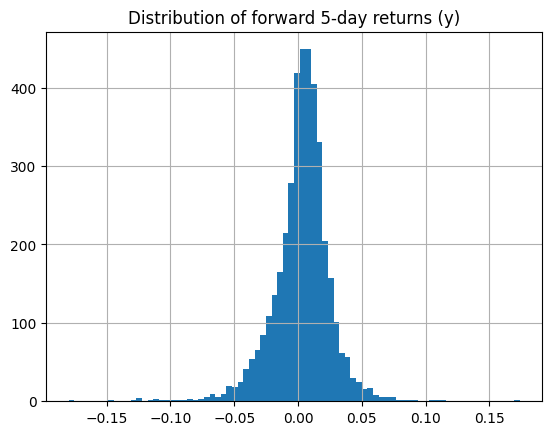

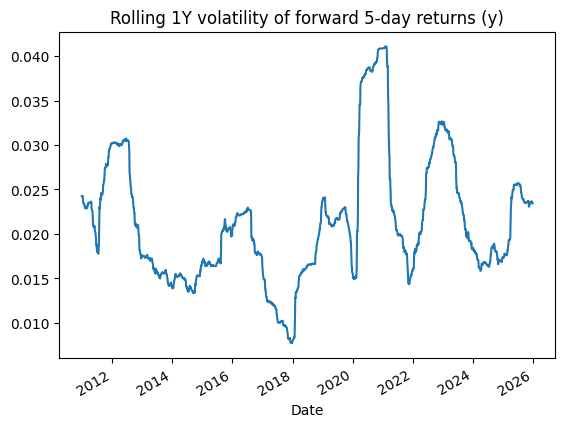

In [31]:
# EDA: How does y look?
import matplotlib.pyplot as plt

plt.figure()
df["y"].dropna().hist(bins=80)
plt.title("Distribution of forward 5-day returns (y)")
plt.show()

plt.figure()
df["y"].dropna().rolling(252).std().plot()
plt.title("Rolling 1Y volatility of forward 5-day returns (y)")
plt.show()

In [32]:
# Feature engineering step

# Momentum
df["mom_5"] = close.pct_change(5)
df["mom_20"] = close.pct_change(20)
df["mom_60"] = close.pct_change(60)

# Moving averages
df["ma_20"] = close.rolling(20).mean()
df["ma_60"] = close.rolling(60).mean()
df["trend_20_60"] = (df["ma_20"] - df["ma_60"]) / df["ma_60"]

# Volatility
df["vol_20"] = df["ret_1d"].rolling(20).std()

# Mean reversion
roll_mean = close.rolling(20).mean()
roll_std = close.rolling(20).std()
df["z_20"] = (close - roll_mean) / roll_std

# We will include more non-price features after the baseline model is tested.

In [33]:
# Cleaning the dataset to drop NaNs

feature_cols = ["mom_5", "mom_20", "mom_60", "trend_20_60", "vol_20", "z_20"]
data = df[feature_cols + ["y"]].dropna()

X = data[feature_cols]
y = data["y"]
data.tail()

Price,mom_5,mom_20,mom_60,trend_20_60,vol_20,z_20,y
Date,,,,,,,
2025-12-17,-0.023518,0.017149,0.012349,0.006404,0.007468,-0.631320,0.031308
2025-12-18,-0.018428,0.020886,0.023249,0.007049,0.007590,-0.202036,0.023475
2025-12-19,0.001234,0.046084,0.037309,0.008668,0.006741,0.393426,0.010667
2025-12-22,0.008996,0.042219,0.037825,0.010107,0.006566,1.083552,0.003183
2025-12-23,0.016384,0.031796,0.039647,0.011026,0.005897,1.659115,-0.008780


In [34]:
eda = df[feature_cols + ["y"]].dropna()

# Sanity: check feature variability (should not be all NaN or constant)
print(eda[feature_cols].describe().T[["mean", "std", "min", "max"]])

# Quick correlation check with target y
eda.corr(numeric_only=True)["y"].sort_values(ascending=False)

                 mean       std       min       max
Price                                              
mom_5        0.002839  0.022487 -0.179693  0.173582
mom_20       0.011342  0.041737 -0.309867  0.230725
mom_60       0.034068  0.064859 -0.301868  0.397892
trend_20_60  0.010615  0.025756 -0.158373  0.079115
vol_20       0.009266  0.005829  0.002010  0.058701
z_20         0.446797  1.254714 -3.793768  3.089443


Price
y              1.000000
vol_20         0.080876
mom_20        -0.069682
z_20          -0.070436
mom_5         -0.087308
trend_20_60   -0.099024
mom_60        -0.119471
Name: y, dtype: float64

In [35]:
# Walk forward training (with Ridge Regression) and testing

tscv = TimeSeriesSplit(
    n_splits=8
)  # Splits data into 8 partitions, so that we can use earlier data for training and later ones for testing

model = Pipeline(
    [("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))]
)  # Builds a pipeline model that standardizes the data (subtract mean, divide by SD), then uses ridge regression

pred = pd.Series(
    index=X.index, dtype=float
)  # Creates a series to store predictions for every date in X

# Loops through our time based splits, uses some for training, some for testing
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]

    model.fit(X_train, y_train)
    pred.iloc[test_idx] = model.predict(
        X_test
    )  # Populates our pred series with the predictions

# Align realized y with pred
out = pd.DataFrame({"y": y, "pred": pred}).dropna()
out.head()

,y,pred
Date,,
2012-01-06,0.008848,0.001006
2012-01-09,0.010311,-0.003067
2012-01-10,0.012701,0.001108
2012-01-11,0.017493,-0.000025
2012-01-12,0.018840,-0.002695


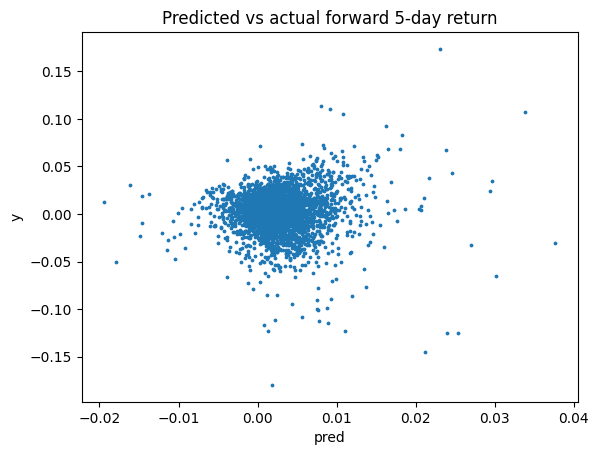

np.float64(0.052065010101035945)

In [36]:
# EDA: Predicted vs actual forward 5-day return
plt.figure()
plt.scatter(out["pred"], out["y"], s=3)
plt.title("Predicted vs actual forward 5-day return")
plt.xlabel("pred")
plt.ylabel("y")
plt.show()

ic = out["pred"].corr(out["y"])
ic

In [37]:
# ============================================================================
# STRATEGY A: BASELINE STRATEGY
# ============================================================================
# Strategy: Use sign of prediction (-1, 0, +1 positions)
# Every day, use the model's prediction of SPY's forward 5-day return.
# If the prediction is positive, go long; if negative, go short.
# ============================================================================

out_simple = out.copy()
out_simple["pos"] = np.sign(out_simple["pred"])  # -1, 0, +1
out_simple["pos_prev"] = out_simple["pos"].shift(1).fillna(0.0)

tcost = 0.0005
out_simple["turnover"] = (out_simple["pos"] - out_simple["pos_prev"]).abs()
out_simple["strat_ret"] = (
    out_simple["pos_prev"] * out_simple["y"] - tcost * out_simple["turnover"]
)


def sharpe(r, periods=252):
    r = r.dropna()
    if r.std() == 0:
        return np.nan
    return np.sqrt(periods) * r.mean() / r.std()  # Annualized Sharpe ratio


sh_simple = sharpe(out_simple["strat_ret"])
sh_simple

np.float64(1.1876559100274313)

Baseline: Every day, use the model’s prediction of SPY’s forward 5-day return.
If the prediction is positive, go long; if negative, go short.


Simple strategy turnover:


count    3512.000000
mean        0.244021
std         0.654471
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: turnover, dtype: float64

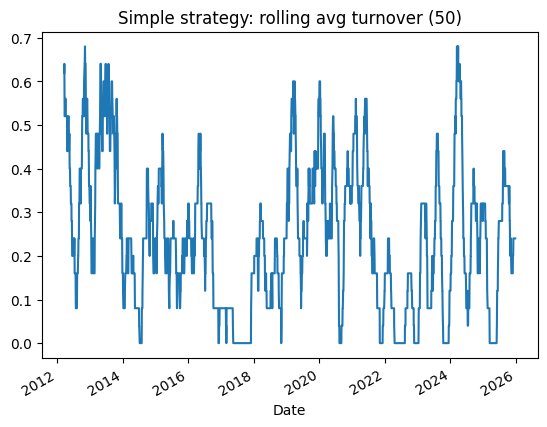

In [38]:
# EDA: Turnover check (Strategy A)
print("Simple strategy turnover:")
display(out_simple["turnover"].describe())

plt.figure()
out_simple["turnover"].rolling(50).mean().plot()
plt.title("Simple strategy: rolling avg turnover (50)")
plt.show()

In [39]:
# Looking at the metrics to evaluate model performance

mse = mean_squared_error(out["y"], out["pred"])
mae = mean_absolute_error(out["y"], out["pred"])
ic = out["y"].corr(out["pred"])  # Information Coefficient

mse, mae, ic

(0.0004761106668880623, 0.015311411021979637, np.float64(0.052065010101035945))

In [40]:
# ============================================================================
# STRATEGY B: RISK-SCALED STRATEGY
# ============================================================================
# Strategy: Use rolling standard deviations of predictions to scale risk
# Positions are scaled based on prediction volatility, clipped to [-1, 1]
# ============================================================================

# Create separate DataFrame for Strategy B to avoid data confusion
out_scaled = out.copy()

# Use rolling standard deviations of predictions to scale risk
scale = out_scaled["pred"].rolling(252).std()
signal = (out_scaled["pred"] / scale).replace([np.inf, -np.inf], np.nan).fillna(0.0)

pos = signal.clip(-1, 1)  # position in [-1, 1]
out_scaled["pos"] = pos

In [41]:
# Calculate trading costs - evals whether strategy is realistic
tcost = 0.0005  # 5 bps per 1.0 change in position (tweakable)

out_scaled["pos_prev"] = out_scaled["pos"].shift(1).fillna(0.0)
out_scaled["turnover"] = (out_scaled["pos"] - out_scaled["pos_prev"]).abs()
out_scaled["strat_ret"] = (
    out_scaled["pos_prev"] * out_scaled["y"] - tcost * out_scaled["turnover"]
)

In [42]:
# Evaluate Strategy B on non-overlapping 5-day periods
out5 = out_scaled.iloc[::5].copy()


def sharpe(r, periods):
    r = r.dropna()
    if r.std() == 0:
        return np.nan
    return np.sqrt(periods) * r.mean() / r.std()  # Calculates annualized Sharpe ratio


sh5 = sharpe(out5["strat_ret"], periods=252 / 5)
bh5 = sharpe(out5["y"], periods=252 / 5)

sh5, bh5

(np.float64(0.4333074913770513), np.float64(1.0285193904191625))

In [43]:
out5[["strat_ret", "y"]].describe()

,strat_ret,y
count,703.000000,703.000000
mean,0.001056,0.002958
std,0.017303,0.020420
min,-0.123501,-0.123501
25%,-0.003582,-0.006523
50%,0.000000,0.004084
75%,0.006864,0.014357
max,0.073630,0.073773


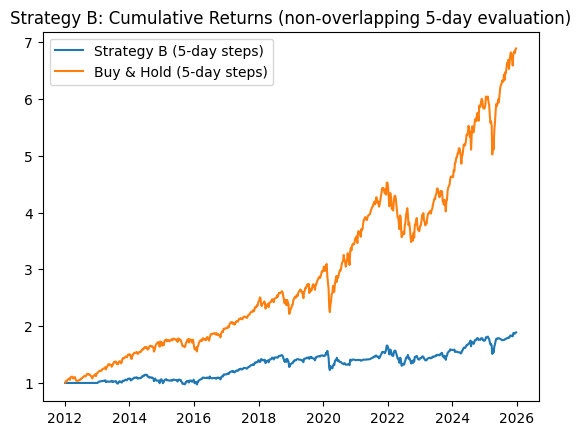

In [44]:
out5["cum_strat"] = (1 + out5["strat_ret"]).cumprod()
out5["cum_bh"] = (1 + out5["y"]).cumprod()

plt.figure()
plt.plot(out5.index, out5["cum_strat"], label="Strategy B (5-day steps)")
plt.plot(out5.index, out5["cum_bh"], label="Buy & Hold (5-day steps)")
plt.legend()
plt.title("Strategy B: Cumulative Returns (non-overlapping 5-day evaluation)")
plt.show()

Goal: predict SPY’s forward 5-day return using regression.

Pipeline:

1. Construct features using only past data (momentum, trend, volatility, etc.).

2. Use time-series cross-validation (walk-forward) to avoid look-ahead bias.

3. Generate out-of-sample predictions

4. Convert predictions into a trading position (pos) and compute strategy returns (for main strategy, strategy B) after transaction costs.

5. Evaluate using Sharpe ratio and equity curve against buy-and-hold.
